## Model Selection Notebook

This notebook will perform model selection on a Kernel SVM to predict binary classification

- Home Win Result
- Not Home Win Result

In [20]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import sem
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import random
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import sem

numFolds = 10

date = '20170217'

In [30]:
random.seed('01191988')

In [31]:
# Load data
data = pd.read_csv('/Users/mtetkosk/Google Drive/Data Science Projects/data/processed/%s_Matches_w_Features.csv'%(date))

In [32]:
for col in data.columns:
    if data[col].dtype == 'object':
        print col

In [33]:
print len(data)
print data.shape

2280
(2280, 196)


In [34]:
home_goals = data['home_team_goal']
away_goals = data['away_team_goal']

In [35]:
del data['home_team_goal']
del data['away_team_goal']

In [36]:
print data.shape

(2280, 194)


In [37]:
## First step is to set up training and holdout set
def Assign_Train_Test(df):
    num = random.randint(1,numFolds)
    return num

In [42]:
data['Train_Test'] = data.apply(Assign_Train_Test, axis = 1)

In [43]:
## Chose holdout set as approx 10% of data
holdout = data[data['Train_Test']==1]
train = data[data['Train_Test']!= 1]

# Remove the train_test variable from the dataframes
del holdout['Train_Test']
del train['Train_Test']

print 'Test length ' + str(len(holdout))
print 'Train length ' + str(len(train))

Test length 246
Train length 2034


In [44]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [45]:
def FitPredict(x_train,y_train,x_test,model):
    
    fit_model = model.fit(x_train,y_train)
    preds = fit_model.predict(x_test)
    
    return preds

def ComputeErrorMetric(y_true,y_pred):
    
    #df = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
    # draw
    #hw_fp = ((df.y_true != 1) & (df.y_pred == 1))
    #hw_tp = ((df.y_true == 1) & (df.y_pred == 1))
    #hw_fn = ((df.y_true == 1) & (df.y_pred != 1))
    #hw_tn = ((df.y_true != 1) & (df.y_pred != 1))

    #true_positive = sum(hw_tp)
    #false_positive = sum(hw_fp)
    #true_negative = sum(hw_tn)
    #false_negative = sum(hw_fn)

    #combined_error_metric = 10.0/13.0*false_positive/(false_positive+true_negative)+3.0/13.0*false_negative/(false_negative+true_positive)
    
    #precision = true_positive / (true_positive + false_positive)
    #recall = true_positive / (true_positive + false_negative)
    
    f1score = f1_score(y_true,y_pred, average='binary')
    precision = precision_score(y_true,y_pred, average='binary')
    recall = recall_score(y_true,y_pred, average = 'binary')
    
    return round(f1score,2), round(precision,4), round(recall,2)

In [46]:
## Use Assign_Train_Test to assign cross-validation folds

train['Fold'] = train.apply(Assign_Train_Test,axis = 1)

train['Fold'].value_counts()   #All folds are approximately equal size

/Users/mtetkosk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


1     234
10    214
7     209
3     209
2     206
8     201
6     200
5     200
9     181
4     180
Name: Fold, dtype: int64

In [47]:
verbose = False

In [48]:
## Set up cross-validation loop

cv_accuracy = []
cv_precision = []
cv_recall = []

#kernel_choice = ['rbf','poly','sigmoid']
n_trees = [50,100,200,300]
depths = [2,3,4,5,6]

outer_param_scores = {}
outer_error_metric = []

summary_error = pd.DataFrame()


for fold in range(1,numFolds+1):
    
    # Outer Cross-Validation
    
    cv_train = train[train['Fold'] != fold]
    cv_test = train[train['Fold'] == fold]
    
    del cv_train['Fold']
    del cv_test['Fold']
    
    y_train = cv_train['Result_Target'].copy()
    x_train = cv_train.copy()
    del x_train['Result_Target']

    
    y_test = cv_test['Result_Target'].copy()
    del cv_test['Result_Target']
    x_test = cv_test.copy()
    
    # Set up inner cross-validation
    
    inner_train = cv_train.copy()
    del cv_train['Result_Target']
    
    inner_train['Inner_Fold'] = inner_train.apply(Assign_Train_Test, axis = 1)
    
    best_hyper_params = {}
    #se = {}
    
    paramComboDict = {}
    error_dict = {}
    outerfold = []
    inner_average = []
    paramnum = []
    paramComboNum = 0
    
    # Iterate thru hyperparameter search
    for k in n_trees:
        #if k == 'poly':
        #    gamma_list = [2,3,4]
        #else:
        #    gamma_list = [.01,.1,.2,.5,1]
        for g in depths:
            
            paramComboNum += 1
            paramComboDict[paramComboNum] ={'Depth': g,
                                            'N_Trees': k}
            if verbose:
                print paramComboNum
                
            error_metric = []
    
            for inner_fold in range(1,numFolds+1):
            
                #print 'Inner Fold: ' + str(inner_fold)
        
                inner_cv_train = inner_train[inner_train['Inner_Fold']!= inner_fold]
                inner_cv_test = inner_train[inner_train['Inner_Fold']== inner_fold]
        
                del inner_cv_train['Inner_Fold']
                del inner_cv_test['Inner_Fold']
        
                y_inner_train = inner_cv_train['Result_Target']
                del inner_cv_train['Result_Target']
                x_inner_train = inner_cv_train.copy()
    
                y_inner_test = inner_cv_test['Result_Target']
                del inner_cv_test['Result_Target']
                x_inner_test = inner_cv_test.copy()
                
                clf = RandomForestClassifier(n_estimators = k, max_depth = g)
                #if k == 'poly':
                #    clf = SVC(kernel = 'poly',degree = g, class_weight = 'balanced')
                #else:
                #    clf = SVC(kernel = k,gamma = g)
                
                preds = FitPredict(x_inner_train,y_inner_train,x_inner_test,clf)
    
                cem, precision,recall = ComputeErrorMetric(y_inner_test,preds)  # Calculate combined error metric
        
                error_metric.append(precision)
              
                #if cem > 0:
                #print 'Precision = ' + str(precision) + ' | ' + 'Recall = ' + str(recall)
                    
            
            avg_error_metric = np.mean(error_metric)
            em_std_err = sem(error_metric)
            
            print 'Fold ' + str(fold) + ' Param Combo Number ' + str(paramComboNum) + ' Avg Precision = ' + str((avg_error_metric - em_std_err))
            outerfold.append(fold)
            inner_average.append(avg_error_metric - em_std_err)
            paramnum.append(paramComboNum)
    
    
    if 'outerfold' in summary_error.columns and'inner_average' in summary_error.columns and 'paramnum' in summary_error.columns:
        temp_df = pd.DataFrame({'outerfold':outerfold,'inner_average':inner_average,'paramnum':paramnum})
        summary_error = pd.concat([summary_error, temp_df])    
    else:   
        summary_error['outerfold'] = outerfold
        summary_error['inner_average'] = inner_average
        summary_error['paramnum'] = paramnum
    
    sub = summary_error[summary_error['outerfold']==fold]
        
    best_params = paramComboDict[sub['paramnum'][sub['inner_average'].idxmax()]]
    
    k = best_params['N_Trees']
    g = best_params['Depth']
    
    print 'Best Params for Outer Fold ' + str(fold) + ' | ' + 'Number of Trees = ' + str(k) + ' | ' + 'Max Depth = ' + str(g)
    
    clf = RandomForestClassifier(n_estimators = k, max_depth = g)  
    
    #if k == 'poly':
    #    clf = SVC(kernel = k, degree = float(g))
    #else:
    #    clf = SVC(kernel = k, gamma = float(g))
    
    preds = FitPredict(x_train,y_train,x_test,clf)
    
    cem, precision,recall = ComputeErrorMetric(y_test,preds)
    
    outer_error_metric.append(precision)
    
    print 'Fold ' + str(fold) + ' Error Metric: ' + str(round(precision,2))
    
    outer_param_scores[sub['paramnum'][sub['inner_average'].idxmax()]] = precision

for key in outer_param_scores.keys():
    if outer_param_scores[key] == max(outer_param_scores.values()):
        best_combo = key
        
best_params = paramComboDict[best_combo]

best_k = best_params['N_Trees']
best_gamma = best_params['Depth']

avg_error_metric = np.mean(outer_error_metric)   
    
    
print '****************************************************'
print 'Average Error Metric= ' + str(avg_error_metric)
print 'Best Parameters: ' + ' Number of Trees = ' + str(best_k) + ' Max Depth = ' + str(best_gamma)

Fold 1 Param Combo Number 1 Avg Precision = 0.643543223991
Fold 1 Param Combo Number 2 Avg Precision = 0.642420244952
Fold 1 Param Combo Number 3 Avg Precision = 0.644857154379
Fold 1 Param Combo Number 4 Avg Precision = 0.634053948009
Fold 1 Param Combo Number 5 Avg Precision = 0.629681765094
Fold 1 Param Combo Number 6 Avg Precision = 0.651833243856
Fold 1 Param Combo Number 7 Avg Precision = 0.648508737276
Fold 1 Param Combo Number 8 Avg Precision = 0.65166628614
Fold 1 Param Combo Number 9 Avg Precision = 0.641828704983
Fold 1 Param Combo Number 10 Avg Precision = 0.641303621066
Fold 1 Param Combo Number 11 Avg Precision = 0.667009456708
Fold 1 Param Combo Number 12 Avg Precision = 0.640071964644
Fold 1 Param Combo Number 13 Avg Precision = 0.640255844922
Fold 1 Param Combo Number 14 Avg Precision = 0.630191771339
Fold 1 Param Combo Number 15 Avg Precision = 0.630827012836
Fold 1 Param Combo Number 16 Avg Precision = 0.664978353385
Fold 1 Param Combo Number 17 Avg Precision = 0.646

## Test on holdout set

In [58]:
## Prepare for test
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

x_train = train.copy()
x_test = holdout.copy()

y_train = x_train['Result_Target']
del x_train['Result_Target']
del x_train['Fold']

y_test = x_test['Result_Target']
del x_test['Result_Target']

clf = RandomForestClassifier(n_estimators = 200, max_depth = 2, random_state = 1988)

preds = FitPredict(x_train,y_train,x_test,clf)
cem, precision, recall = ComputeErrorMetric(y_test,preds)

print 'Holdout Set Error Metric = ' + str(round(precision,2))
print 'Precision = ' + str(precision)
#print 'Recall = ' + str(recall)

## Metric to beat SVM = 0.5301
## Metric after optimizing gamma / decision_function SVM = .5465
## Metric Random Forest n_estimators = 200, max_depth = 2 = .65

Holdout Set Error Metric = 0.65
Precision = 0.6508


In [59]:
df_confusion = pd.crosstab(y_test,preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0.0,1.0,All
Actual,,,
0.0,116,22,138
1.0,67,41,108
All,183,63,246


### Finally, build model based off of entire dataset

In [79]:
x_train = data.copy()

y_train = x_train['Result_Target'].copy()
del x_train['Result_Target']

clf = SVC(kernel = 'poly', degree = 2)

fit_clf = clf.fit(x_train,y_train)

In [80]:
with open('/Users/mtetkosk/Google Drive/Data Science Projects/models/%s_SVC_Model_Champion.pkl'%(date), 'wb') as f:
    pickle.dump(fit_clf, f)

## Output Results

In [81]:
Results_Df = pd.DataFrame({'Date': date, 'Holdout Precision': precision, 'Kernel': best_k, 'Degree': best_gamma}, index=[0])

Results_Df.to_csv('/Users/mtetkosk/Google Drive/Data Science Projects/models/%s_SVM_Model_Champion.csv'%(date))

## Betting Analysis

In [60]:
test_home_odds = x_test['Average_Home_Odds'].copy()
test_away_odds = x_test['Average_Away_Odds'].copy()
draw_odds = x_test['Average_Draw_Odds'].copy()
bet_preds = preds.copy()
actual_results = y_test.copy()

In [61]:
Betting_df = pd.DataFrame({'Home_Odds':test_home_odds,'Away_Odds':test_away_odds,'Draw_Odds': draw_odds,'Model_Preds':bet_preds,'Result': y_test.copy()})
Betting_df = Betting_df.reset_index(drop=True)
Betting_df[Betting_df['Model_Preds']==1][:25]

,Away_Odds,Draw_Odds,Home_Odds,Model_Preds,Result
3,12.50,5.92,1.20,1.0,1.0
4,8.75,4.45,1.39,1.0,1.0
8,4.15,3.51,1.84,1.0,1.0
11,16.83,6.92,1.14,1.0,1.0
12,15.17,6.92,1.15,1.0,1.0
13,4.62,3.40,1.77,1.0,1.0
18,12.83,5.50,1.24,1.0,1.0
30,5.77,3.82,1.57,1.0,1.0
39,7.67,4.22,1.43,1.0,0.0
40,3.88,3.23,1.98,1.0,0.0


In [65]:
## Betting Analysis Function

def BettingAnalysis(df,purse,bet):
    initial_purse = purse
    purse_track = []
    for match in range(len(df)):
        pred = df['Model_Preds'][match]
        result = df['Result'][match]
        home_odds = df['Home_Odds'][match]
        away_odds = df['Away_Odds'][match]
        draw_odds = df['Draw_Odds'][match]
        if pred == 0:
            purse_track.append(purse)
            continue
        if pred == 1 and pred == result:
            #if pred == 1:
            #    win = round(bet*home_odds,2)-bet
            #    purse += win
            #if pred == -1: #simulate no bet
            #    win = round(bet*away_odds,2)-bet
            #    purse += win
            #purse_track.append(purse)
            if pred == 1:
                win = round(bet*home_odds,2)-bet
                assert win > 0
                purse += win
        else:
            purse = purse - bet
            purse_track.append(purse)
    
    if purse > initial_purse:
        profit = purse-initial_purse
        #return 'You profited ' +str(round(profit,2)) +'!'
        return purse_track
    if purse == initial_purse:
        #return 'You broke even!'
        return purse_track
    if purse < initial_purse:
        loss = purse-initial_purse
        #return 'You lost ' + str(abs(round(loss,2))) + 'now you\'re broke!'
        return purse_track

In [66]:
purse_track = BettingAnalysis(Betting_df,100,5)

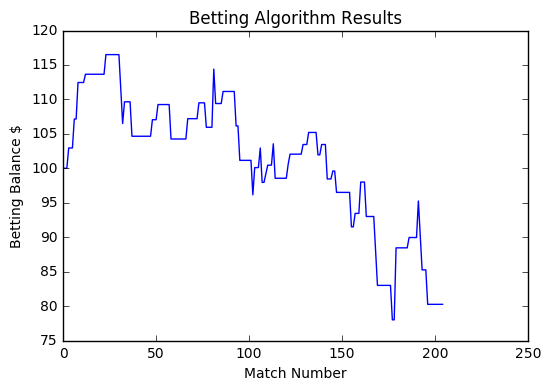

In [67]:
plt.plot(purse_track)
plt.xlabel('Match Number')
plt.ylabel('Betting Balance $')
plt.title('Betting Algorithm Results')